In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import nltk
import re
import datetime as dt
from PIL import Image
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from glob import glob

# 2. Text analysis

This part of the notebook will containn different analyses of the song lyrics. The main methods which will be used are TF-IDF scores which will be used to create wordclouds, sentiment analysis, dispersion plots and lastly LSA will be performed to calculate similarities between artists. Most of these methods will be applied in multiple scenarios. In general, the songs will be analysed with respect to the decade in which they were released and also according to the genre to which they belong.

In [9]:
class MyColorFunctor():
    def __init__(self, tfidf):
        self.tfidf = tfidf
        self.high = max(tfidf.values())
        self.low = min(tfidf.values())

    def scale(self, x):
        return 260 - (x - self.low)/(self.high - self.low) * 200

    def __call__(self,word,font_size,position,orientation,random_state=None,**kwargs):
        return "hsl(%d, 80%%, %d%%)" % (self.scale(self.tfidf[word]), 50)

def text_happiness_score(token_list):
    text = [w for w in token_list if w in words_with_score]
    fdist = nltk.FreqDist(text)
    return sum([happiness_score[w] * fdist.freq(w) for w in set(text)])

def lexical_diversity(text):
    return len(set(text)) / len(text)

### 2.0.1 Preprocessing lyrics

Prior to conducting any analysis, the lyrics are preprocessed in order to prepare the data. All lyrics are tokenized and lemmatized using nltk and all tokens containing a non-alphabetic character are removed. All characters are made lowercase and for every song each word is only counted once. This is done since it is typical for songs to contain a lot of repetition (as it makes the lyrics easier to remember).

In [2]:
songData = pd.read_pickle('songData_sorted.df')

In [3]:
Stopwords = set(w for w in stopwords.words('english'))
lem_fun = WordNetLemmatizer()

all_tokens = []
all_tokens_repeat = []
for t in songData.lyrics:
    tokens = list(lem_fun.lemmatize(token.lower()) for token in nltk.word_tokenize(t) if token.isalpha() and lem_fun.lemmatize(token.lower()) not in Stopwords)
    all_tokens_repeat.append(tokens)
    all_tokens.append(list(set(tokens)))

songData['tokens'] = all_tokens
songData['tokens_repeat'] = all_tokens_repeat

### 2.0.2 Fraction of genres pr. decade
Since the data stems from the Billboard hot 100 chart it is possible to show how dominant some of the genres have been through time. The figure below shows how much of the music on the chart was labelled as the given genre in each decade. Note that most songs have plenty of genre tags, so the ratios do not sum to 1 (also only the most popular genres are shown).

In [13]:
decade_genre_df = pd.DataFrame(None, columns=top_genres)
percentage_df = pd.DataFrame(None, columns=top_genres)
decade_genre_list = {decade: [0]*len(top_genres) for decade in range(1960, 2021, 10)}

for tokens, release, genres in zip(songData.tokens, songData.released, songData.genres):
    decade = max(int(int(release[:4]) / 10) * 10, 1960)
    for i, genre in enumerate(top_genres):
        if genre in genres:
            decade_genre_list[decade][i] += 1

for decade, counts in decade_genre_list.items():
    decade_genre_df.loc[decade] = decade_genre_list[decade]
    decade_count = sum(decade_genre_list[decade])
    percentage_df.loc[decade] = [c/decade_count for c in decade_genre_list[decade]]

decade_genre_df

,pop,rock,rap,r&b,country,soul,singer-songwriter,trap,ballad,uk,funk,dance,electronic,folk,jazz,blues
1960,3711,909,64,753,382,506,86,2,71,102,94,2,0,80,69,58
1970,2570,1268,43,844,375,582,288,0,192,165,293,19,3,75,24,34
1980,2482,1231,103,606,102,287,250,0,174,248,199,89,37,14,29,13
1990,1453,621,700,763,229,309,138,2,163,103,60,94,72,16,13,7
2000,1241,937,1004,748,613,218,304,31,287,64,48,63,70,24,14,15
2010,1814,650,2011,873,760,129,482,848,427,242,45,231,301,45,19,20
2020,432,72,851,254,155,39,189,571,95,47,13,46,61,35,4,2


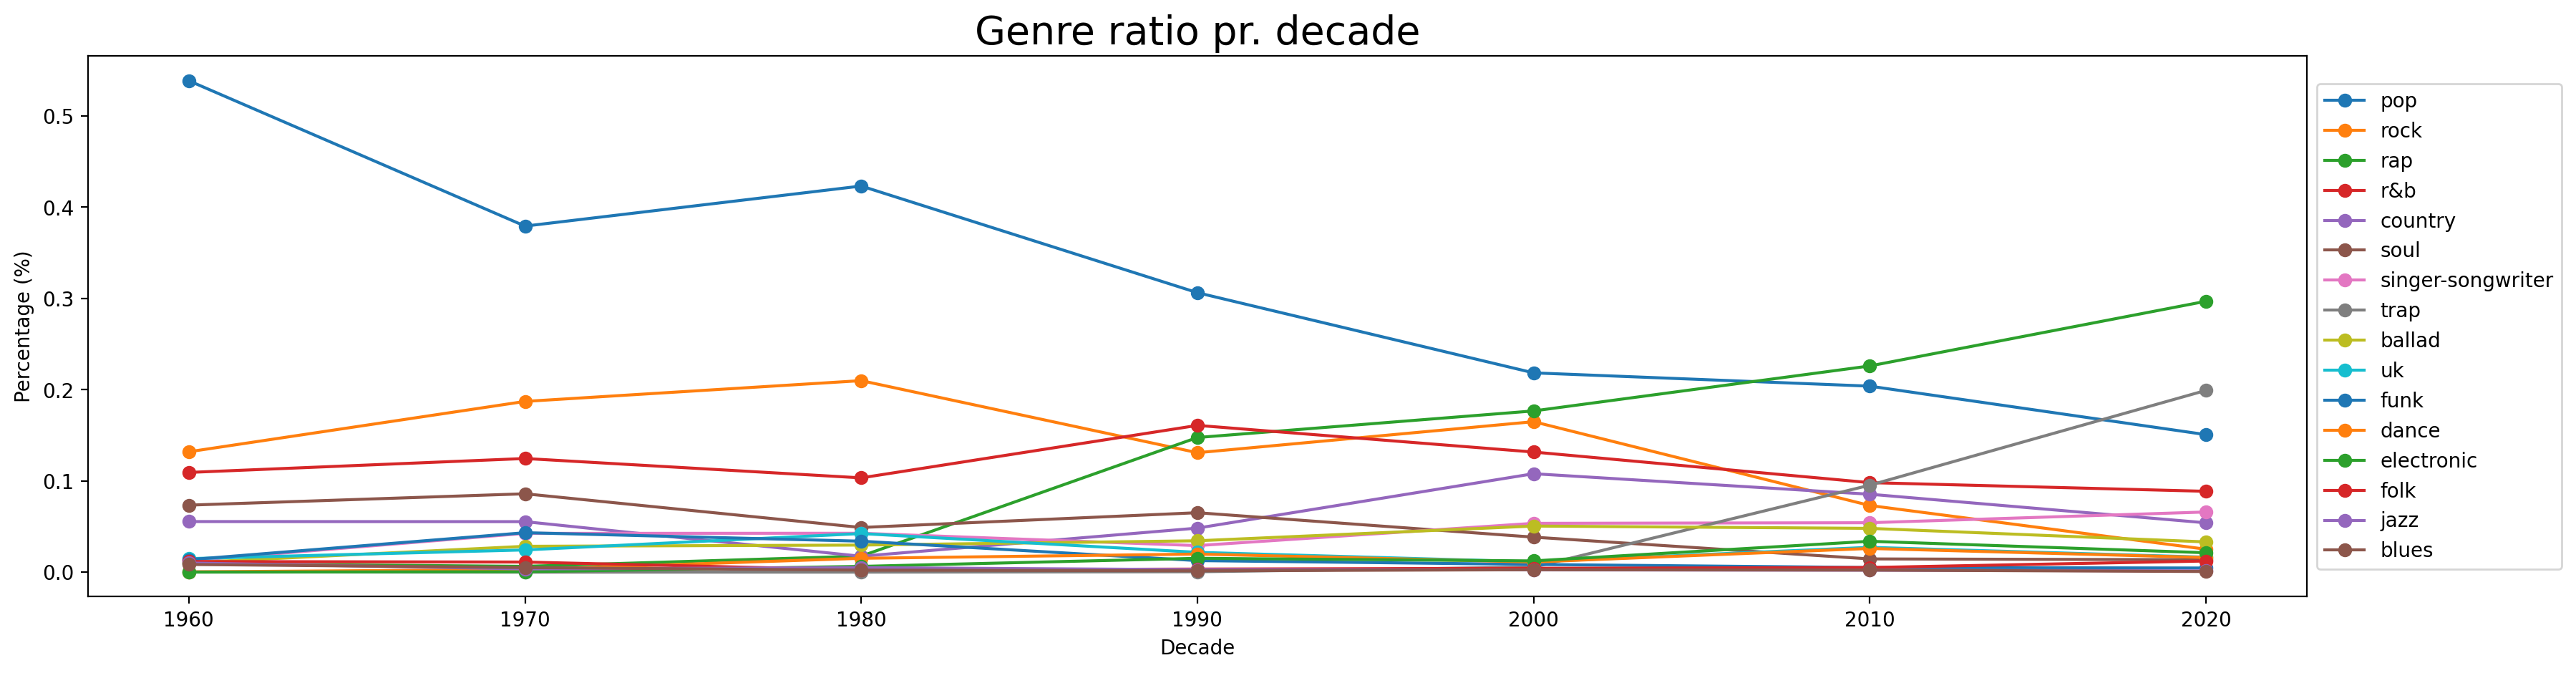

In [12]:
plt.figure(figsize=(20,5), dpi=200)
n_decades = len(percentage_df)
for col in percentage_df.columns:
    plt.plot(range(n_decades), percentage_df[col], 'o-', label=col)
plt.title('Genre ratio pr. decade', size=20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(range(n_decades), decade_genre_list.keys())
plt.xlabel('Decade')
plt.ylabel('Percentage (%)')
plt.show()

This graph and the 

## 2.1 TF-IDF

The TF-IDF (term frequency, inverse document frequency) score is a measure of how much a term relates to the characteristics of a document. In this study, _terms_ are of course words in the lyrics of songs and _documents_ can be either decade, genre or artist - according to the scenario we are interested in analysing. The TF is simply how many times a given term occurs in the document and IDF is a measure of how unique the term is given by:
\begin{equation}
\text{idf}(t, D) = \log\left(\frac{N}{|d\in D:t\in d|}\right)
\end{equation}
where $t$ is a term and $D$ is the set of documents, denoted as the _corpus_. The TF-IDF is the product of TF and IDF, meaning that terms are most important if they occur frequently in the given document while also not appearing in any other document.

### 2.1.1 Genres
The data contains 582 genres. Many of these are sub-genres of the main genres which we all know and love. Using all genres is thus not desirable since it is not relevant how _pop_ relates to _dance-pop_ or _alternative-pop_, but it is relevant how _pop_ relates to _rap_ and _rock_. Therefore, the genres which will constitute the corpus were handselected from the genres which appear the most from 1960-2022.

In [7]:
genre_count = defaultdict(lambda: 0)

for genres in songData.genres:
    for genre in genres:
        genre_count[genre] += 1

# Handpick genres
top_genres = ['pop', 'rock', 'rap', 'r&b', 'country', 'soul',
              'singer-songwriter', 'trap', 'ballad', 'uk',
              'funk', 'dance', 'electronic', 'folk',
              'jazz', 'blues']
N = len(top_genres)

In [8]:
# Calculate all genre documents
genre_docs = defaultdict(lambda: [])

for tokens, genres in zip(songData.tokens, songData.genres):
    for genre in genres:
        genre_docs[genre] += tokens

# Choose only those in "top_genres"
top_genre_docs = {genre: doc for genre, doc in genre_docs.items() if genre in top_genres}

# Calculate the IDF scores for all terms in the corpus.
def idf(term: str, docs: {int: {str}}, log=np.log2):
    n = len(docs.keys())
    d = sum(term in doc for doc in docs.values())
    return log(n/d)

top_genre_docs_set = {genre: set(doc) for genre, doc in top_genre_docs.items()}
all_terms = set()
for doc in top_genre_docs.values():
    all_terms = all_terms.union(set(doc))
genre_idf_dict = {t: idf(t, top_genre_docs_set) for t in all_terms}


# Loop through all top genres and calculate TF-IDF
for genre, doc in top_genre_docs.items():
    print('='*50)
    print(genre)

    fdist = nltk.FreqDist(doc)
    N = len(doc)

    stock_tfidf = {t: fdist.freq(t) * genre_idf_dict[t] for t in set(doc)}
    tfidf_keys = [k[0] for k in sorted(stock_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]]

    print(f'{"TF":>14} {"TFIDF":>25}')
    i = 1
    for (tf_word, _), iftdf_word in zip(fdist.most_common(10), tfidf_keys[:10]):
        print(f'{str(i)+".":<4} {tf_word:<8} {_/N:.4f} {iftdf_word:>17} {stock_tfidf[iftdf_word]:.5f}')
        i += 1
    print('')

pop
            TF                     TFIDF
1.   know     0.0100            chorus 0.00009
2.   love     0.0099     miscellaneous 0.00007
3.   oh       0.0077            broken 0.00006
4.   like     0.0077             party 0.00006
5.   got      0.0072          breaking 0.00006
6.   time     0.0070           breathe 0.00005
7.   go       0.0066           rainbow 0.00005
8.   one      0.0063            happen 0.00005
9.   na       0.0062             nigga 0.00005
10.  see      0.0062            spoken 0.00005

folk
            TF                     TFIDF
1.   know     0.0085      annihilation 0.00031
2.   like     0.0079        squandered 0.00025
3.   time     0.0065            ragged 0.00022
4.   wa       0.0064            sunlit 0.00021
5.   love     0.0063             canal 0.00021
6.   one      0.0057            knowed 0.00021
7.   come     0.0056             birch 0.00021
8.   go       0.0055         blindness 0.00018
9.   say      0.0052            magpie 0.00018
10.  day      0

As is evident by the output above, the TF-IDF scores succeed in highlighting a lot of the characteristics of the different genres.

### 2.1.2 Decade

In [ ]:
decade_docs = defaultdict(lambda: [])
decade_genre_count = defaultdict(lambda: defaultdict(lambda: 0))
genre_decade_docs = defaultdict(lambda: defaultdict(lambda: []))
decade_genre_df = pd.DataFrame(None, columns=top_genres)
percentage_df = pd.DataFrame(None, columns=top_genres)
decade_genre_list = {decade: [0]*len(top_genres) for decade in range(1960, 2021, 10)}

for tokens, release, genres in zip(songData.tokens, songData.released, songData.genres):
    decade = max(int(int(release[:4]) / 10) * 10, 1960)
    decade_docs[decade] += tokens
    for genre in genres:
        decade_genre_count[decade][genre] += 1
        genre_decade_docs[genre][decade] += tokens
    for i, genre in enumerate(top_genres):
        if genre in genres:
            decade_genre_list[decade][i] += 1

for decade, counts in decade_genre_list.items():
    decade_genre_df.loc[decade] = decade_genre_list[decade]
    decade_count = sum(decade_genre_list[decade])
    percentage_df.loc[decade] = [c/decade_count for c in decade_genre_list[decade]]

decade_docs = {k: v for k, v in sorted(decade_docs.items(), key=lambda item: int(item[0]))}

### 2.1.3 Artist

## 2.2 Wordcloud

### 2.2.1 Genre

### 2.2.2 Decade

### 2.2.3 Artist

## 2.3 Dispersion plot

## 2.4 Sentiment analysis

### 2.4.1 Genre

### 2.4.2 Decade

### 2.4.3 Artist